<a href="https://colab.research.google.com/github/andrew-na-git/Stable-Diffusion/blob/William_branch/Colout_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!make -C sparse_gaussian_elimination a.so

make: Entering directory '/content/sparse_gaussian_elimination'
make: 'a.so' is up to date.
make: Leaving directory '/content/sparse_gaussian_elimination'


In [2]:
#@title Preamble
import os
import threading
import torch.multiprocessing as multiprocessing
import functools
import random
from math import log, sqrt, exp

import matplotlib.pyplot as plt
import scipy.stats as stats

import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import sparse
from scipy.special import logsumexp, softmax, log_softmax
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.optim import Adam, AdamW, SGD

from kfp import construct_A, construct_B, diffusion_coeff, marginal_prob_std, construct_R, construct_P, construct_P_block, construct_R_block, gauss_seidel, solve_pde, jacobi
from network import ScoreNet

import PIL

np.random.seed(2)
torch.manual_seed(2)

#torch.set_default_device('cuda')

# create a.so if doesnt exists
# if not os.path.isfile("../sparse_gaussian_elimination/a.so"):
#     os.system("make -C ../sparse_gaussian_elimination a.so")
cifar = CIFAR10('.', download=True)

Files already downloaded and verified


In [3]:
#@title Construct the grid and Initial values
batch_size = 1 #@param
N = 20
H = 28
W = 28
epoch = 5000 #@param
eps = 1e-6 #@param
lr = 1e-3 #@param

channels = 3
dt = 1/N
sigma = 25 #@param
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [4]:
#@title Download mnist dataset
#data_loader = DataLoader(list(filter(lambda i: i[1] == 5, mnist))[:1], shuffle=True, generator=torch.Generator(device='cuda'))
cifar_data = cifar.data[np.array(cifar.targets) == batch_size] # grab the fives

# sample 5 images for training
cifar_data = cifar_data[np.random.choice(list(range(len(cifar_data))), 1, replace=False)]

252 8


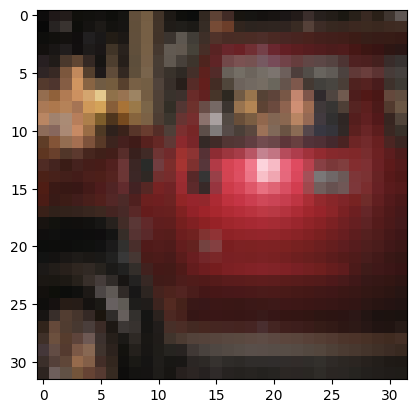

1.0 0.0


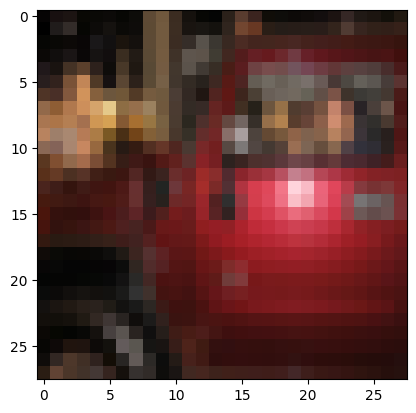

In [5]:
#@title Cropping the image
cropped_image_g = np.array(PIL.Image.fromarray(np.array(cifar_data[0])).convert("L").crop((0, 0, 28, 28)))
cifar_data_list_grey = [torch.Tensor(cropped_image_g)]

cifar_data_list = []
cifar_data_list_tensor = []
for i in range(batch_size):
  cropped_image_rgb = np.array(PIL.Image.fromarray(np.array(cifar_data[i])).convert("RGB").crop((0, 0, 28, 28)))
  cifar_data_list.append((cropped_image_rgb - cropped_image_rgb.min())/(cropped_image_rgb.max() - cropped_image_rgb.min())) # normalized to [0, 1]
  # cifar_data_list = [cropped_image_rgb]
  cifar_data_list_tensor.append(torch.Tensor(cifar_data_list[0].transpose((2, 0, 1))))

  print(cifar_data[i].max(), cifar_data[i].min())
  plt.imshow(cifar_data[i])
  plt.show()

  print(cifar_data_list[i].max(), cifar_data_list[i].min())
  plt.imshow((cifar_data_list[i] - cifar_data_list[i].min())/(cifar_data_list[i].max() - cifar_data_list[i].min()))
  plt.show()

In [10]:
#@title Defining pde diffusion per thread
def diffuse(x, m, dm, channel, time_, g, scores):

  y_train = []
  for j in range(H):
    y_train.append(x[channel][j, :])
  y_train = np.concatenate(y_train)
  x_train = []
  for l in range(W):
    x_train.append(x[channel][:, l])
  x_train = np.concatenate(x_train)

  xy_train = np.vstack([x_train, y_train])
  kde_kernel = stats.gaussian_kde(xy_train)
  xy_sample = kde_kernel.resample(seed=0)
  m[0, channel] = kde_kernel.logpdf(xy_train)
  dx = 1/H
  dy = 1/W

  A_block = []
  for i in range(1, N):
    f = np.zeros((H*W))
    df = np.zeros((H*W))
    A = construct_A(dx, dy, dt, f, df, g(time_[i]), scores[i-1, channel].reshape((H*W)), H, W)#
    if i == 1:
      A_block = sp.linalg.block_diag(A)
    else:
      A_block = sp.linalg.block_diag(A_block, A)
      A_block[(i-1)*(H*W):i*(H*W), (i-2)*(H*W):(i-1)*(H*W)] = -np.eye((H*W))

  B_block = []
  for i in range(1, N):
    B = construct_B(m[i-1, channel], i)
    B_block.append(B)
  B_block = np.concatenate(B_block)
  m[1:, channel] = solve_pde(A_block, B_block, mode='sparse').reshape((-1, H*W))

  img_log_prob = m[:, channel].reshape((-1, H, W))
  dm[:, channel, 1:-1] = (img_log_prob[:, :-2] - img_log_prob[:, 2:])/(2*dx)
  dm[:, channel, 0] = (img_log_prob[:, 0] - img_log_prob[:, 1])/(dx)
  dm[:, channel, -1] = (img_log_prob[:, -2] - img_log_prob[:, -1])/(dx)
  dm[:, channel, :, 1:-1] = (img_log_prob[:, :, :-2] - img_log_prob[:, :, 2:])/(2*dy)
  dm[:, channel, :, 0] = (img_log_prob[:, :, 0] - img_log_prob[:, :, 1])/(dy)
  dm[:, channel, :, -1] = (img_log_prob[:, :, -2] - img_log_prob[:, :, -1])/(dy)

In [ ]:
#@title Precompute score labels by solving the PDE
threads = [None] * channels

m = np.zeros((N, channels, H*W), dtype=np.float32)
m_prev = np.ones((N, channels, H*W), dtype=np.float32)
scores = np.zeros((N, channels, H, W), dtype=np.float32) # initial scores guess
dm = np.zeros_like(scores, dtype=np.float32)
tol = 1e-6 #@param
max_iter = 1000 #@param
res = 1
e = 0
while res > tol:
  for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
    # we want to sample from random time steps to construct training samples
    time_ = np.linspace(eps, 1, N).astype(np.float32)

    # diffuse all three channels concurrently
    for ch in range(channels):
      diffuse(data, m, dm, ch, time_, diffusion_coeff_fn, scores)
      # threads[ch] = threading.Thread(target=diffuse, args=[data, m, dm, ch, time_, diffusion_coeff_fn, scores])
      # threads[ch].start()

    # for thread in threads:
    #   thread.join()

    scores = dm.copy()

    if e == max_iter:
      print(f'No convergence')
      break

    res = np.linalg.norm(m - m_prev)#/np.linalg.norm(m_prev)
    print(f'residual at iteration {e}: {res}')

    m_prev = m.copy()
    e += 1

scores_label = scores.copy()

1it [00:26, 26.68s/it]


residual at iteration 0: 161.3462677001953


0it [00:00, ?it/s]

In [ ]:
#@title Show the score labels
print(scores_label[0].max(), scores_label[0].min())
plt.imshow(((scores_label[0] - scores_label[0].min())/(scores_label[0].max() - scores_label[0].min())).transpose(1, 2, 0))
plt.show()
print(scores_label[-1].max(), scores_label[-1].min())
plt.imshow(((scores_label[-1] - scores_label[-1].min())/(scores_label[-1].max() - scores_label[-1].min())).transpose(1, 2, 0))
plt.show()

In [9]:
#@title Denoising network training
def loss_fn(model, x, label, diffusion_coeff, marginal_prob_std, eps=1e-5):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.tensor(np.sort(np.random.uniform(eps, 1., N)).astype(np.float32))
  # we encode the label into the initial data using the reverse ODE
  diff_std2 = diffusion_coeff(2 * random_t)
  for i in range(1, N):
    x[i] = x[i-1] - 0.5 * label[i-1] * diff_std2[i-1] * dt
  std = marginal_prob_std(random_t)
  z = torch.randn_like(x)
  # we perturb the image by the forward SDE conditional distribution
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  # loss = torch.mean((diff_std2) * torch.sum((score * std[:, None, None, None] - label)**2, dim=(1, 2, 3)) / (2 * diff_std2))
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3))) # original loss from tutorial
  return loss

In [10]:
#@title Function for training on a thread
def diffuse_train(init_x, channel, epoch, diffusion_coeff, marginal_prob_std, label):
  model_score = ScoreNet(marginal_prob_std=marginal_prob_std)
  optimizer = Adam(model_score.parameters(), lr=lr)
  model_score.train();

  scores_label = torch.tensor(label)[:, channel][:, None]

  for e in range(epoch):
    loss = loss_fn(model_score, init_x[:, channel][:, None], scores_label, diffusion_coeff, marginal_prob_std)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f'\nloss at channel {channel}: {loss}')
  file = f'model_cifar_thread_{channel}.pth'
  torch.save(model_score.state_dict(), file)
  print(f"model for thread {channel} has been saved\n")

In [11]:
#@title Train each channel on a thread
if os.path.exists(f'model_cifar_thread_0.pth'):
  print(f'removing saved weights for thread 0\n')
  os.remove(f'model_cifar_thread_0.pth')
if os.path.exists(f'model_cifar_thread_1.pth'):
  print(f'removing saved weights for thread 1\n')
  os.remove(f'model_cifar_thread_1.pth')
if os.path.exists(f'model_cifar_thread_2.pth'):
  print(f'removing saved weights for thread 2\n')
  os.remove(f'model_cifar_thread_2.pth')

processes = [None] * channels
init_x = torch.zeros((N, channels, H, W))

for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
  for ch in range(channels):
    init_x[:, ch] = data[ch]

  # train all three channels concurrently
  for ch in range(channels):
    processes[ch] = multiprocessing.Process(target=diffuse_train, args=[init_x, ch, epoch, diffusion_coeff_fn, marginal_prob_std_fn, scores_label])
    processes[ch].start()

  for process in processes:
    process.join()

0it [02:21, ?it/s]Process Process-3:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-01ffb1f64502>", line 12, in diffuse_train
    loss.backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 492, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages/torch/autograd/__init__.py", line 251, in backward
    Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Process Process-2:
KeyboardInterrupt
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-inp

KeyboardInterrupt: 

In [ ]:
#@title Define the ODE sampler (double click to expand or collapse)
from scipy import integrate
## The error tolerance for the black-box ODE solver
error_tolerance = 1e-6 #@param
def ode_sampler(score_model,
                marginal_prob_std,
                diffusion_coeff,
                batch_size=64,
                atol=error_tolerance,
                rtol=error_tolerance,
                device='cpu',
                z=None,
                eps=1e-3):
  """Generate samples from score-based models with black-box ODE solvers.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that returns the standard deviation
      of the perturbation kernel.
    diffusion_coeff: A function that returns the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    atol: Tolerance of absolute errors.
    rtol: Tolerance of relative errors.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    z: The latent code that governs the final sample. If None, we start from p_1;
      otherwise, we start from the given z.
    eps: The smallest time step for numerical stability.
  """
  t = torch.ones(batch_size, device=device)
  # Create the latent code
  if z is None:
    initial_x = torch.randn(batch_size, 1, H, W, device=device) \
      * marginal_prob_std(t)[:, None, None, None]
  else:
    initial_x = z + torch.randn(batch_size, 1, H, W, device=device) \
      * marginal_prob_std(t)[:, None, None, None]

  shape = initial_x.shape

  def score_eval_wrapper(sample, time_steps):
    """A wrapper of the score-based model for use by the ODE solver."""
    sample = torch.tensor(sample, device=device, dtype=torch.float32).reshape(shape)
    time_steps = torch.tensor(time_steps, device=device, dtype=torch.float32).reshape((sample.shape[0], ))
    with torch.no_grad():
      score = score_model(sample, time_steps)
    return score.cpu().numpy().reshape((-1,)).astype(np.float64)

  def ode_func(t, x):
    """The ODE function for use by the ODE solver."""
    time_steps = np.ones((shape[0],)) * t
    g = diffusion_coeff(torch.tensor(t)).cpu().numpy()
    return  -0.5 * (g**2) * score_eval_wrapper(x, time_steps)

  # Run the black-box ODE solver.
  res = integrate.solve_ivp(ode_func, (1., eps), initial_x.reshape(-1).cpu().numpy(), rtol=rtol, atol=atol, method='RK45')
  print(f"\nNumber of function evaluations: {res.nfev}")
  x = [res.y[:, 0].reshape(shape)]
  T = len(res.t)
  for i in range(N-2):
    idx = int(i + (T/N))
    x.append(res.y[:, idx].reshape(shape))
  x.append(res.y[:, -1].reshape(shape))
  x = np.concatenate(x, axis = 0)
  return x

In [ ]:
#@title Function for threading ODE sampler
import torch
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# function for sampling on a thread
def diffuse_sample(data_x, channel, samples, diffusion_coeff, marginal_prob_std):

  model_score = ScoreNet(marginal_prob_std=marginal_prob_std)
  file = f'model_cifar_thread_{channel}.pth'
  ckpt = torch.load(file)
  model_score.load_state_dict(ckpt)
  model_score.eval();

  sample_batch_size = batch_size
  sampler = ode_sampler

  # Generate samples using the specified sampler.
  output = sampler(model_score,
                  marginal_prob_std,
                  diffusion_coeff,
                  sample_batch_size)

  samples.append(output)

In [ ]:
#@title Sample each channel on a thread
threads = [None] * channels
samples = []

for idx, data in tqdm(enumerate(cifar_data_list_tensor)):
  # diffuse all three channels concurrently
  for ch in range(channels):
    threads[ch] = threading.Thread(target=diffuse_sample, args=[data, ch, samples, diffusion_coeff_fn, marginal_prob_std_fn])
    threads[ch].start()

  for thread in threads:
    thread.join()

  samples = np.concatenate(samples, axis = 1)
  for i in range(samples.shape[0]):
    print(f'{samples[i].mean(), samples[i].std()}')
    plt.imshow(((samples[i] - samples[i].min())/(samples[i].max() - samples[i].min())).transpose(1, 2, 0))
    plt.show()